In [3]:
import io
import os
from pathlib import Path
from google.oauth2 import service_account
from google.cloud import vision
from collections import defaultdict
import mysql.connector
import re

In [ ]:
cnx = mysql.connector.connect(user='xxx', password='xxx', database='pairs')
cursor = cnx.cursor()

credentials = service_account.Credentials.from_service_account_file('/xxx')
client = vision.ImageAnnotatorClient(credentials=credentials)

# 画像読み込み
google_dict = defaultdict(str)
src = sorted(Path('/xxx').glob('*.jpg'))

for i, path in enumerate(src):
    if i <= 68518:
        continue
    print("{}:{}".format(i, path))
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    response = client.annotate_image({
      'image': {'content': content},
      'features': [{'type': vision.enums.Feature.Type.SAFE_SEARCH_DETECTION},
                   {'type': vision.enums.Feature.Type.LABEL_DETECTION}]
    })
    

    file_name = str(path).split("/")[5]
    file_regex = re.match(r'(.*)_(.*)\.jpg', file_name)
    id = file_regex.group(1)
    number_photo = file_regex.group(2)
    labels = [""] * 10
    for i, label in enumerate(response.label_annotations):
        labels[i] = label.description
    descriptions = [""] * 10
    safe = response.safe_search_annotation
    adult = response.safe_search_annotation.adult
    spoof = response.safe_search_annotation.spoof
    racy = response.safe_search_annotation.racy
    created_date = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
    
    add_user = ("INSERT INTO vision "
           "(id, number_photo, label1, label2, label3, label4, label5, label6, label7, label8, label9, label10, adult, spoofed, racy, created_date) "
           "VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)")
    data_user = (id, number_photo, labels[0], labels[1], labels[2], labels[3], labels[4], labels[5], labels[6], labels[7], labels[8], labels[9], adult, spoof, racy, created_date)
    
    """
    update_user = ("UPDATE vision "
           "SET label1 = %s, label2 = %s, label3 = %s, label4 = %s, label5 = %s, label6 = %s, label7 = %s, label8 = %s, label9 = %s, label10 = %s, label11 = %s, label12 = %s, label13 = %s, label14 = %s, label15 = %s, label16 = %s, label17 = %s, label18 = %s, label19 = %s, label20 = %s, label21 = %s, label22 = %s, label23 = %s, label24 = %s, label25 = %s, label26 = %s, label27 = %s, label28 = %s, label29 = %s, label30 = %s "
           "WHERE id = %s and number_photo = %s")
    data_user = (labels[0], labels[1], labels[2], labels[3], labels[4], labels[5], labels[6], labels[7], labels[8], labels[9], labels[10], labels[11], labels[12], labels[13], labels[14], labels[15], labels[16], labels[17], labels[18], labels[19], labels[20], labels[21], labels[22], labels[23], labels[24], labels[25], labels[26], labels[27], labels[28], labels[29], id, number_photo)
    """
    try:
        cursor.execute(add_user, data_user)
        cnx.commit()
    except:
        import traceback
        traceback.print_exc()
        break
cursor.close()
cnx.close()

In [1]:
import mysql.connector
import pandas as pd
import pandas.io.sql as psql
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
import numpy as np

In [2]:
age_list = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]

In [3]:
df_age_name = pd.DataFrame(
    {'age': age_list},
    columns=['age'])

In [4]:
class Pairs:
    def __init__(self):
        self._cnx = mysql.connector.connect(user='xxx', password='xxx', database='pairs')
        self._cursor = self._cnx.cursor()

In [5]:
p = Pairs()

In [6]:
data = psql.read_sql("select vision.*, users.good, users.age from vision, users where vision.id = users.id", p._cnx)
data.replace('500+', 500, inplace=True)
data = data.astype({'good': 'int16'})
data = data.set_index(["age"])
remove_list = ["", "human hair color", "smile", "black hair", "hairstyle", "forehead", "product", "footwear", "shoe", "mouth", "person", "lady", "girl", "eyebrow", "cheek", "chin", "hair", "lip", "nose", "face", "neck", "head"]

In [7]:
df_label = data.loc[:, "label1" : "label10"].stack().reset_index()
df_label = df_label.rename(columns={0: 'label_name'})
df_label = df_label.groupby(["age", 'label_name']).size().reset_index()
df_label = df_label.rename(columns={0: 'label_count'})
df_label = df_label[~df_label['label_name'].isin(remove_list)]
df_label = df_label.sort_values(["age", "label_count"], ascending=[True, False])

/home/iwata/myenv/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


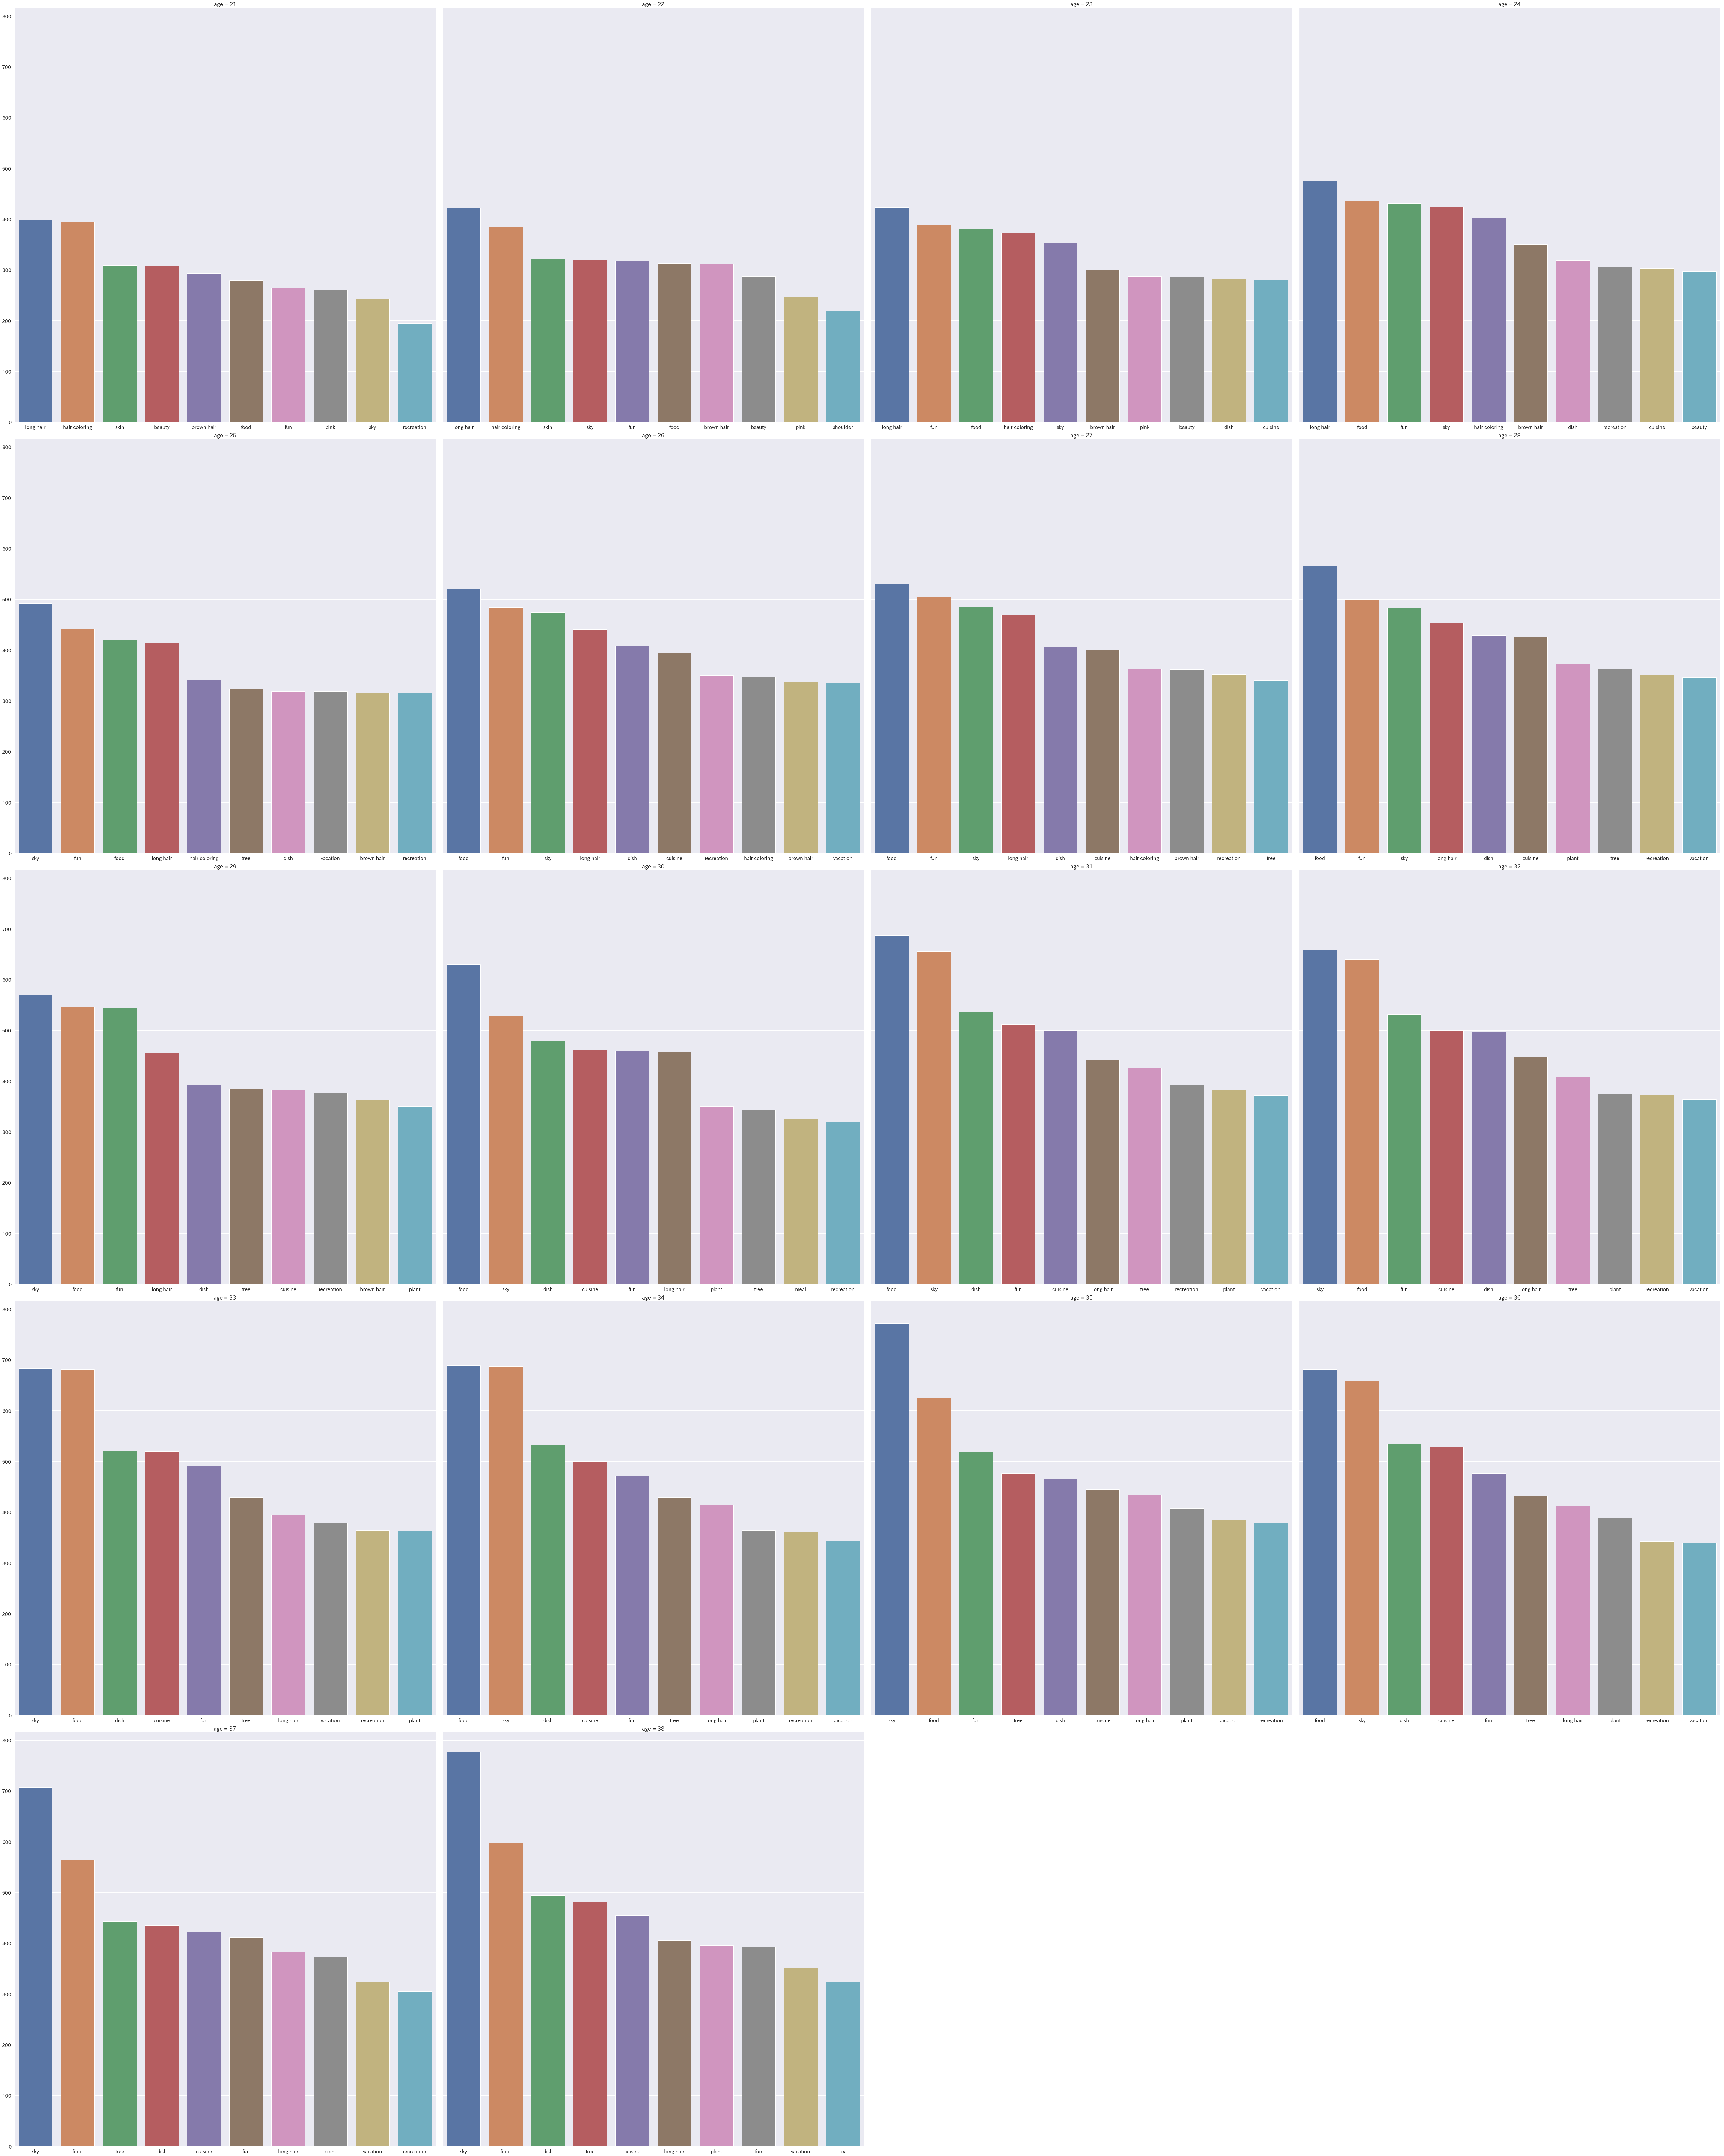

In [8]:
g = sns.FacetGrid(df_label, col="age", size=20, sharex=False, col_wrap=4)

def limit_barplot(data, **kws):
    sns.barplot(data.label_name[0:10], data.label_count[0:10])

g.map_dataframe(limit_barplot)

In [9]:
list_label_name = df_label["label_name"].unique()
df_age_label = pd.DataFrame(columns=["age", "label_name"])
for age in age_list:
    ages = [age] * len(list_label_name)
    df_label_name = pd.DataFrame(
        {'age': ages,
         'label_name': list_label_name},
        columns=['age', 'label_name'])
    df_age_label = df_age_label.append(df_label_name)

In [10]:
df_age_label = df_age_label.astype({'age': 'int16'})

In [11]:
df = pd.merge(df_age_label, df_label, on=["age", "label_name"], how='left').fillna(0).sort_values("label_count", ascending=False)
df['count_rank'] = df.groupby('label_name')['label_count'].rank(ascending=False, method="max")
df["sum_label_name"] = df.groupby('label_name')["label_count"].transform(sum)

[Text(0,0,'girl'),
 Text(0,0,'product'),
 Text(0,0,'forehead'),
 Text(0,0,'hairstyle'),
 Text(0,0,'chin'),
 Text(0,0,'nose'),
 Text(0,0,'cheek'),
 Text(0,0,'black hair'),
 Text(0,0,'smile'),
 Text(0,0,'human hair color'),
 Text(0,0,'eyebrow'),
 Text(0,0,'sky'),
 Text(0,0,'food'),
 Text(0,0,'face'),
 Text(0,0,'fun'),
 Text(0,0,'long hair'),
 Text(0,0,'dish'),
 Text(0,0,'cuisine'),
 Text(0,0,'hair'),
 Text(0,0,'tree')]

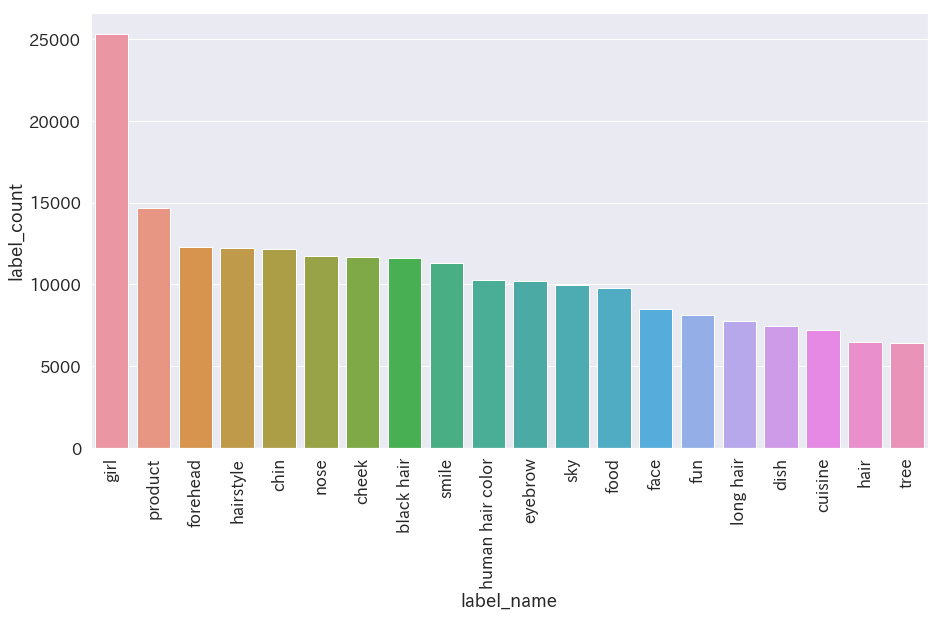

In [12]:
df_count = data.loc[:, "label1" : "label10"].stack().reset_index()
df_count = df_count.rename(columns={0: 'label_name'})
df_count = df_count.groupby(['label_name']).size().reset_index()
df_count = df_count.rename(columns={0: 'label_count'})
df_count = df_count[df_count['label_name'] != ""]
df_count = df_count.sort_values(["label_count"], ascending=[False])
plt.figure(figsize=(15,8))
ax = sns.barplot(x="label_name", y="label_count", data=df_count.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

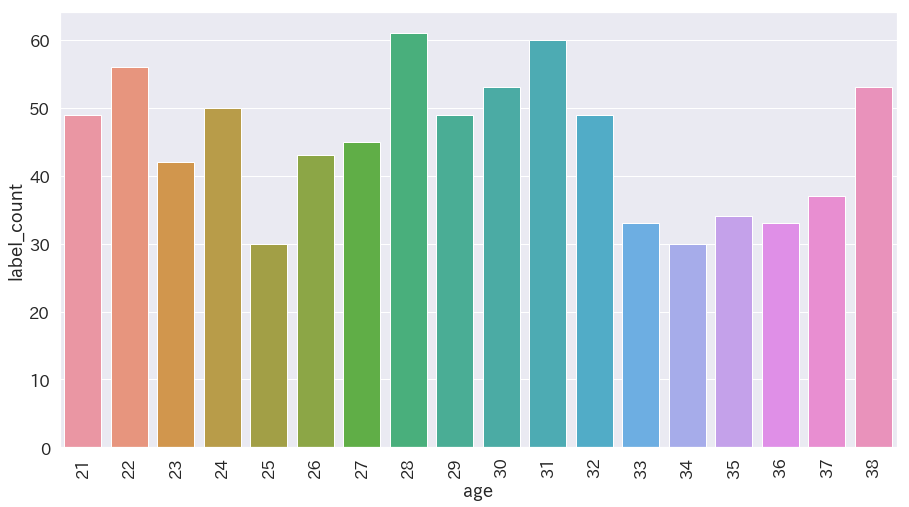

In [13]:
df_standing = df[df["label_name"] == "kimono"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_standing)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

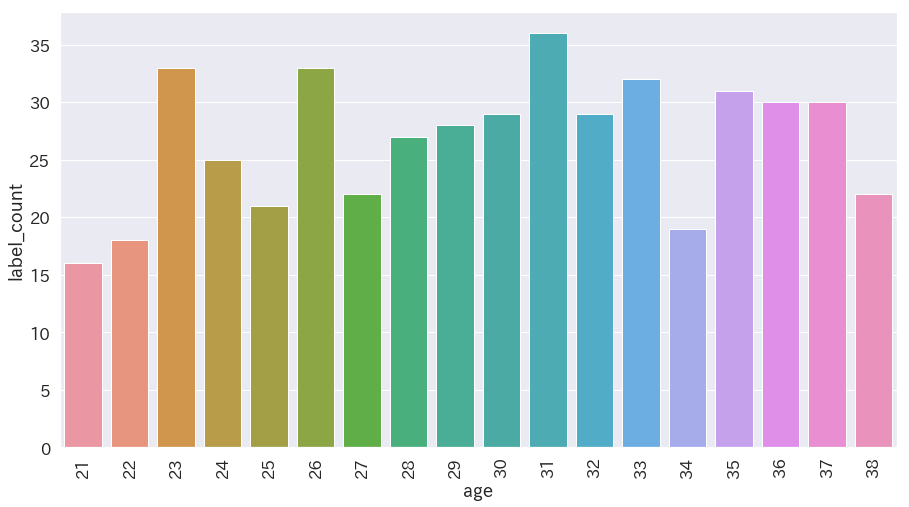

In [15]:
df_abdomen = df[df["label_name"] == "abdomen"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_abdomen)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

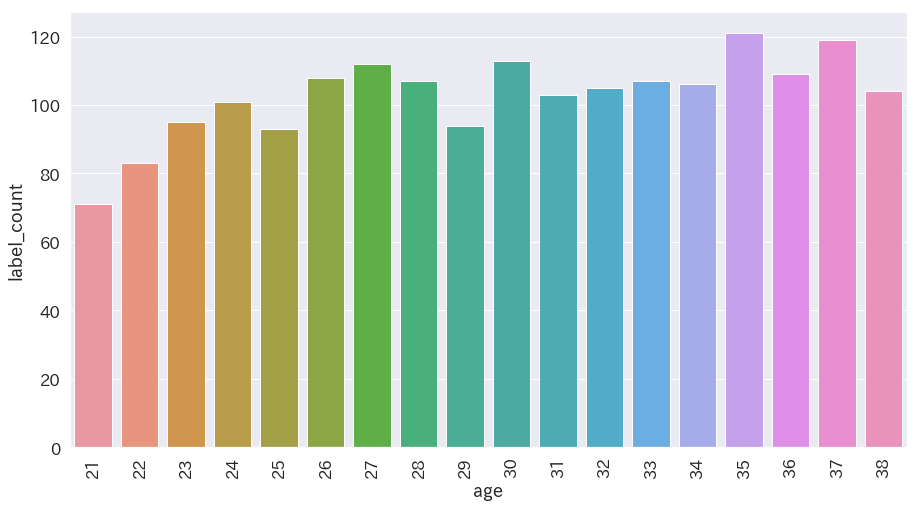

In [22]:
df_visioncare = df[df["label_name"] == "vision care"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_visioncare)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

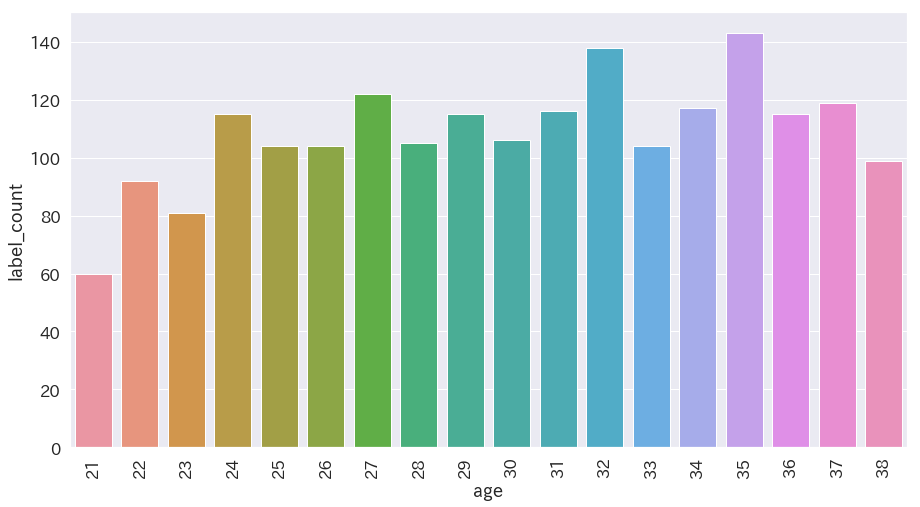

In [23]:
df_selfie = df[df["label_name"] == "selfie"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_selfie)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

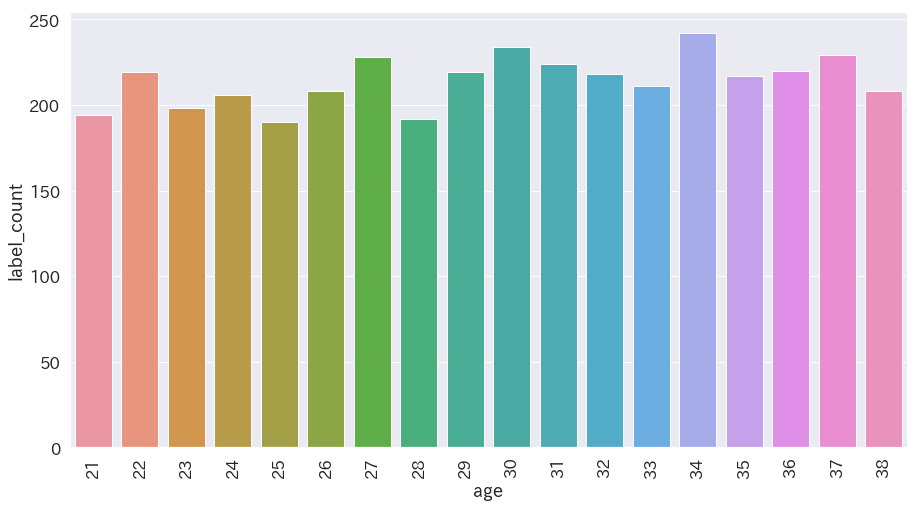

In [24]:
df_shoulder = df[df["label_name"] == "shoulder"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_shoulder)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

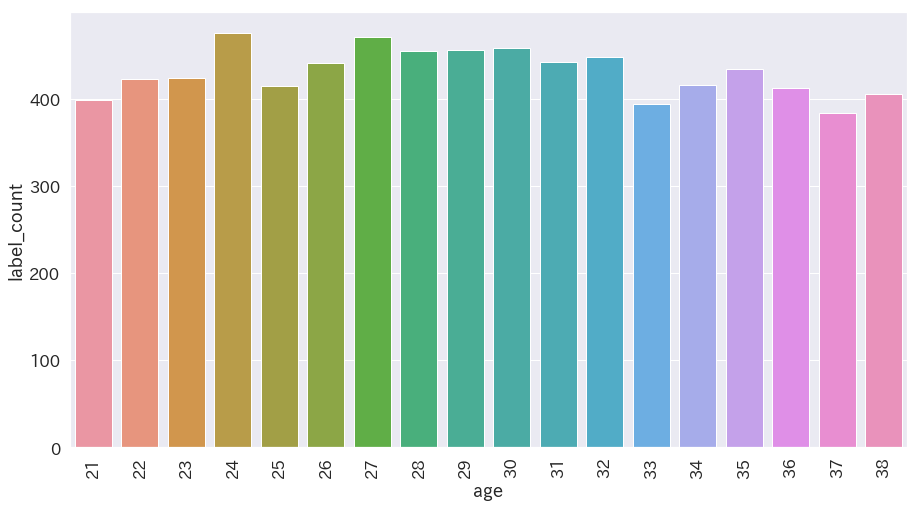

In [25]:
df_longhair = df[df["label_name"] == "long hair"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_longhair)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

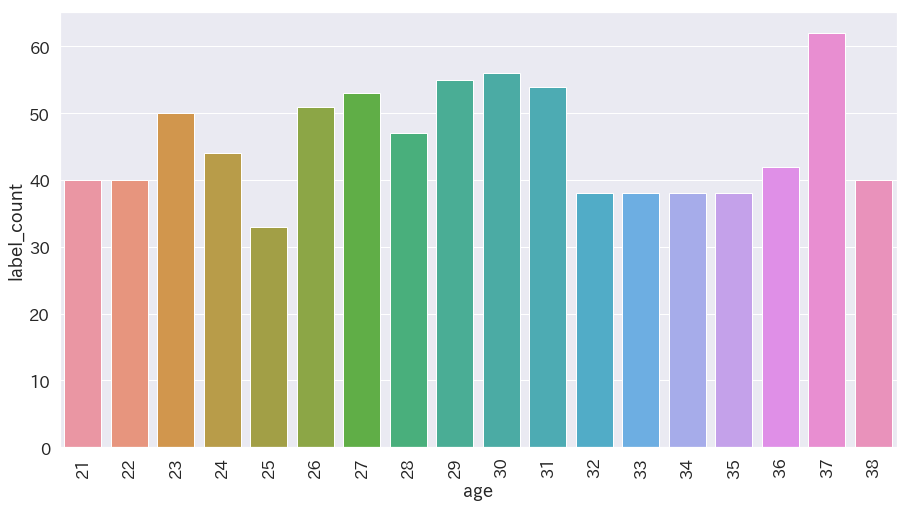

In [26]:
df_dress = df[df["label_name"] == "dress"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_dress)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

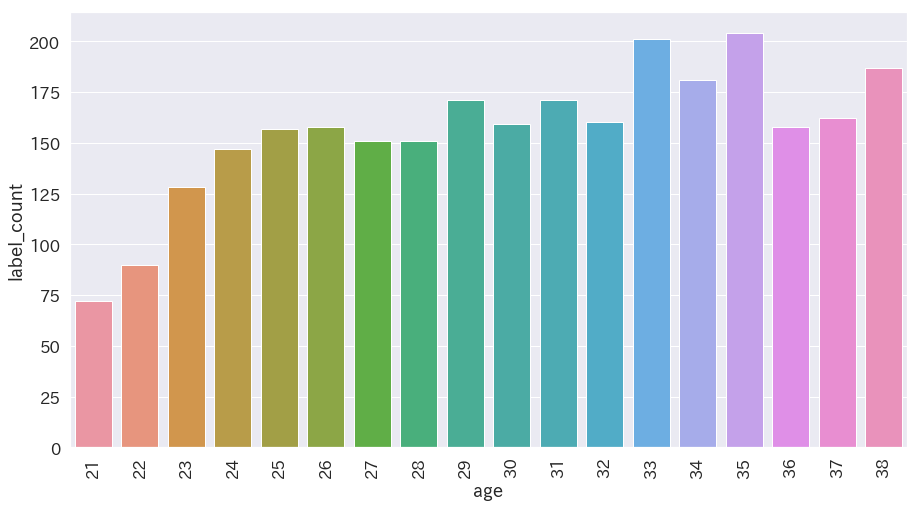

In [27]:
df_city = df[df["label_name"] == "city"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_city)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

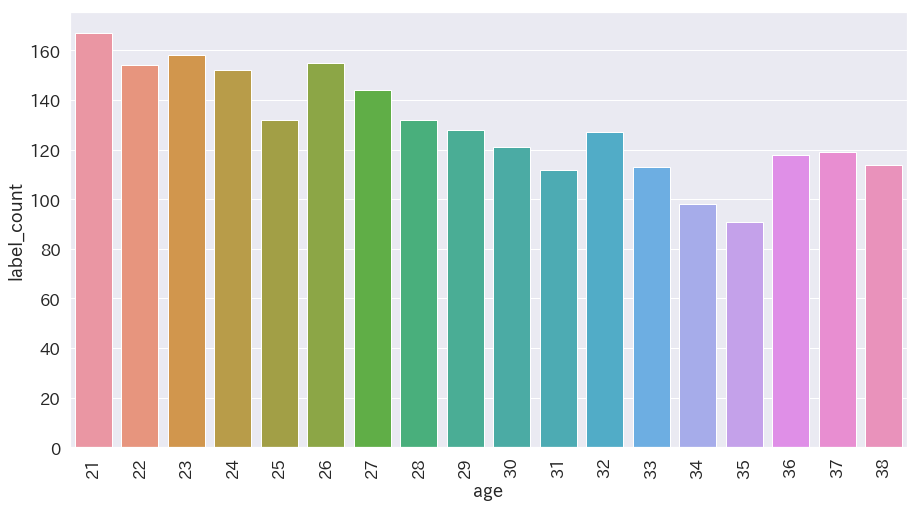

In [28]:
df_bangs = df[df["label_name"] == "bangs"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_bangs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

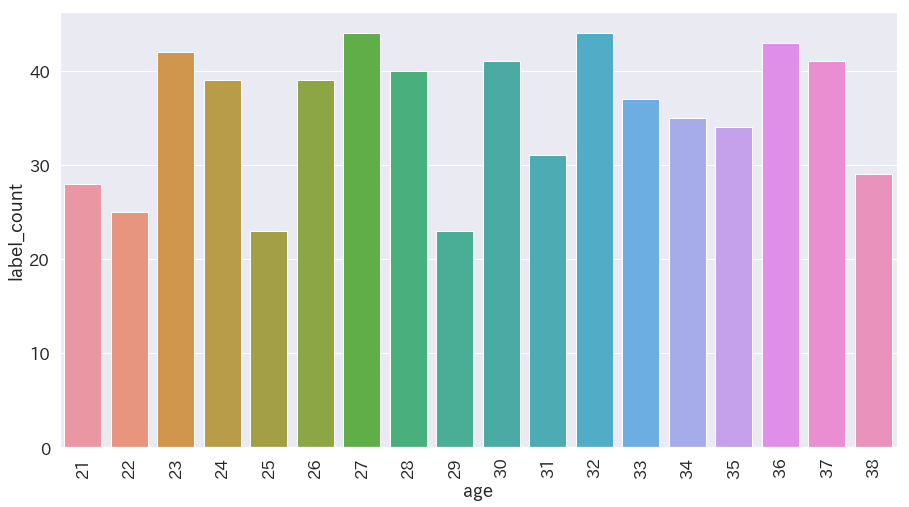

In [29]:
df_sunglasses = df[df["label_name"] == "sunglasses"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_sunglasses)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

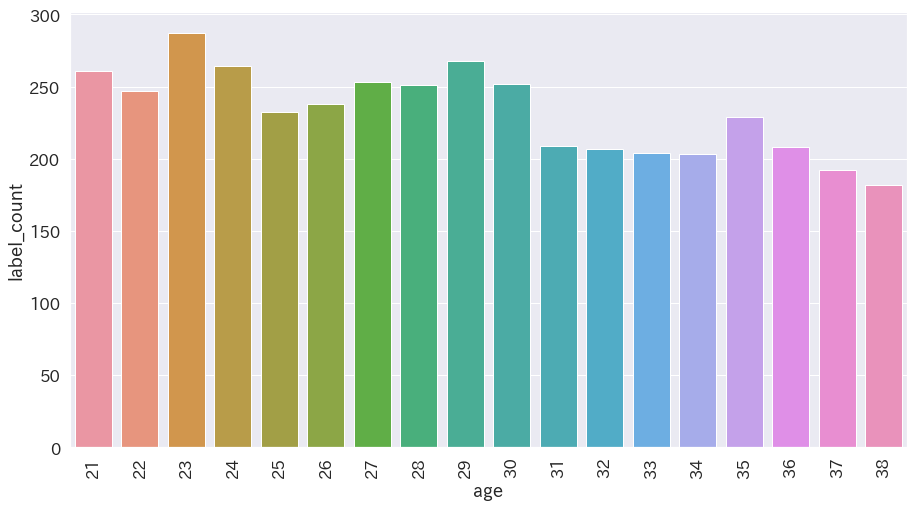

In [30]:
df_pink = df[df["label_name"] == "pink"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_pink)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

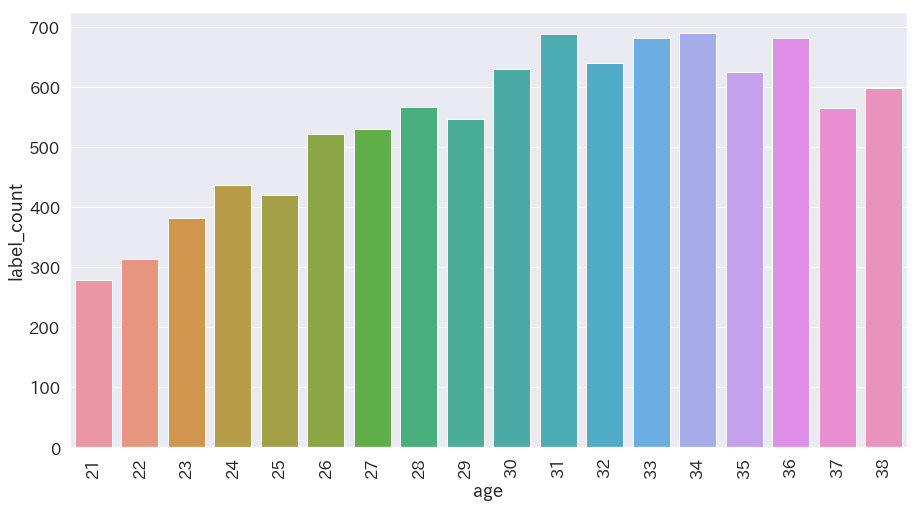

In [31]:
df_food = df[df["label_name"] == "food"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_food)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

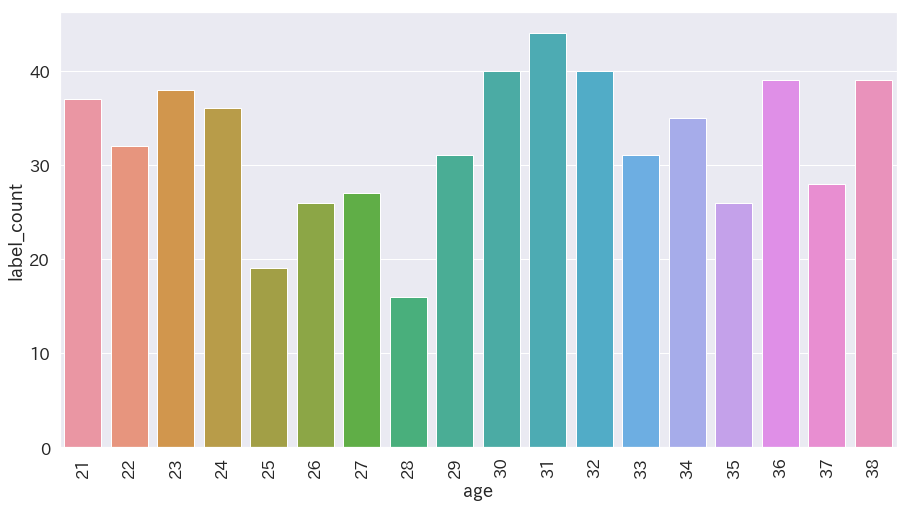

In [32]:
df_blond = df[df["label_name"] == "blond"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_blond)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

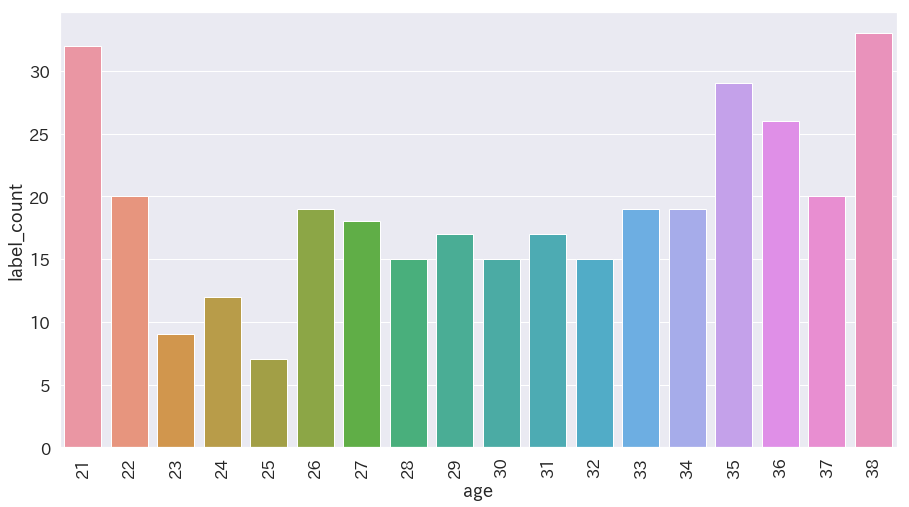

In [33]:
df_bw = df[df["label_name"] == "black and white"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_bw)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

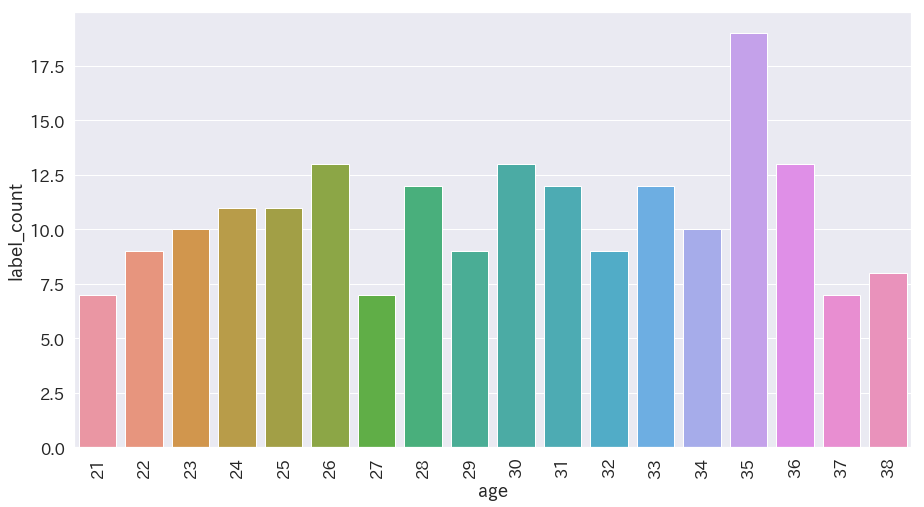

In [34]:
df_swimwear = df[df["label_name"] == "swimwear"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_swimwear)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

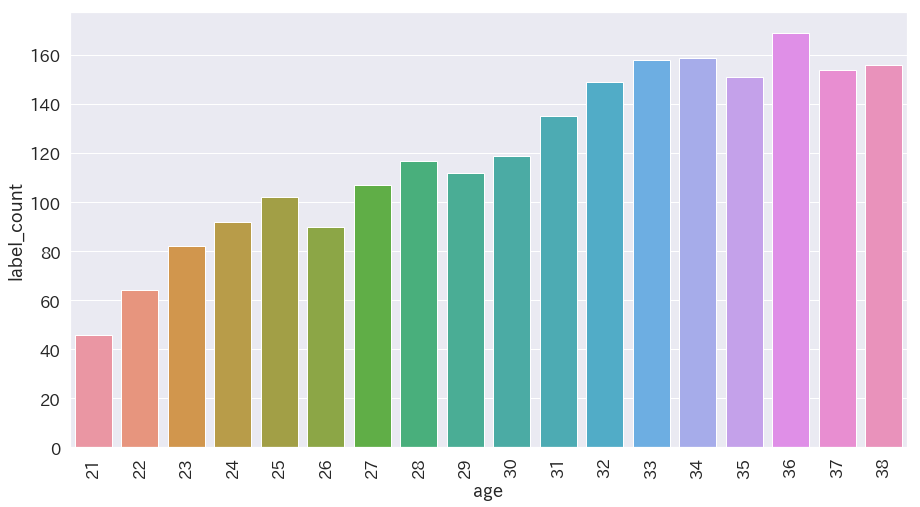

In [35]:
df_beach = df[df["label_name"] == "beach"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_beach)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

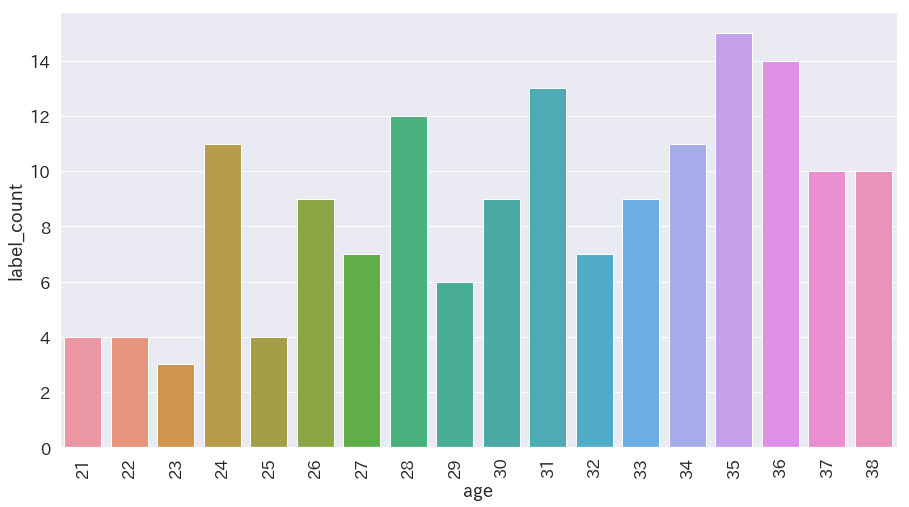

In [36]:
df_muscle = df[df["label_name"] == "muscle"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_muscle)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

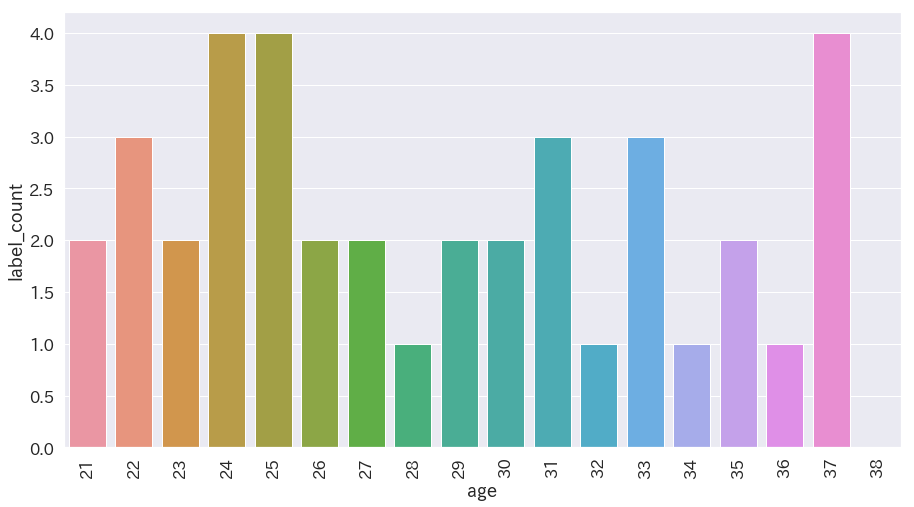

In [37]:
df_undergarment = df[df["label_name"] == "undergarment"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_undergarment)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

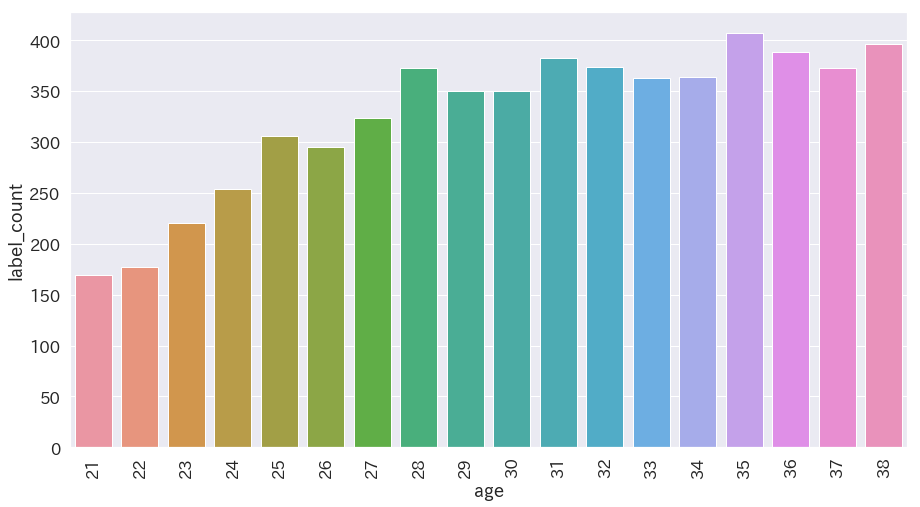

In [38]:
df_plant = df[df["label_name"] == "plant"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_plant)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

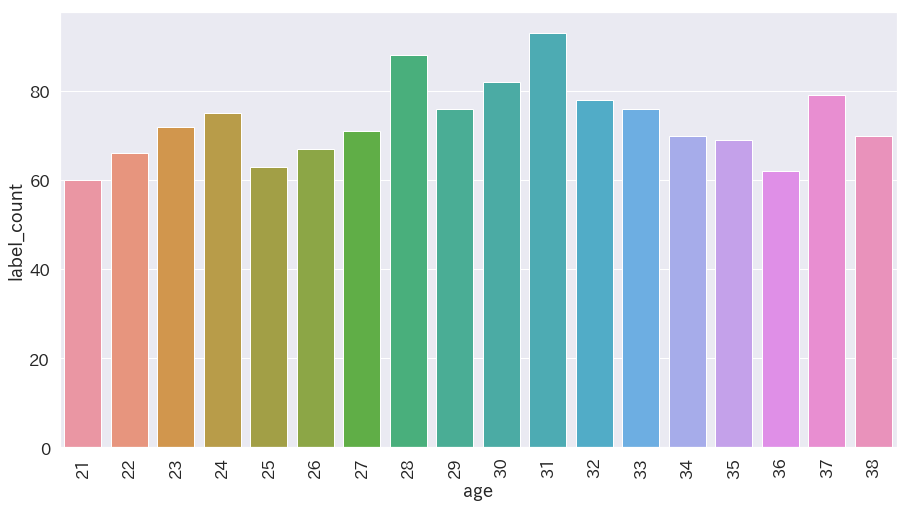

In [39]:
df_skin = df[df["label_name"] == "leg"]
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='label_count', data=df_skin)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0,0,'21'),
 Text(0,0,'22'),
 Text(0,0,'23'),
 Text(0,0,'24'),
 Text(0,0,'25'),
 Text(0,0,'26'),
 Text(0,0,'27'),
 Text(0,0,'28'),
 Text(0,0,'29'),
 Text(0,0,'30'),
 Text(0,0,'31'),
 Text(0,0,'32'),
 Text(0,0,'33'),
 Text(0,0,'34'),
 Text(0,0,'35'),
 Text(0,0,'36'),
 Text(0,0,'37'),
 Text(0,0,'38')]

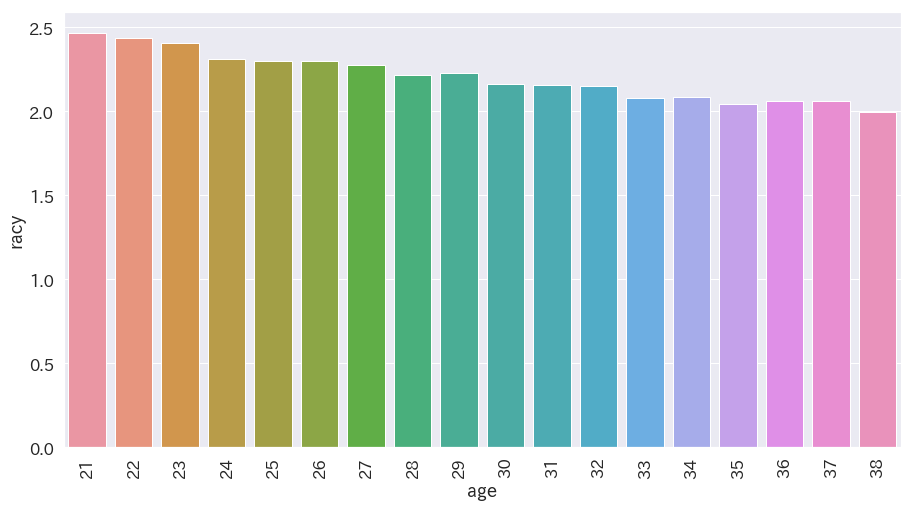

In [42]:
df_racy = data.groupby(['age']).mean()
df_racy = df_racy.sort_values(['racy'], ascending=False)
df_racy = df_racy.reset_index()
plt.figure(figsize=(15,8))
ax = sns.barplot(x='age', y='racy', data=df_racy)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)